In [11]:
# If your Colab has an old TFDS, uncomment the next line once:
# !pip install -q --upgrade tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

tf.random.set_seed(42)
AUTOTUNE = tf.data.AUTOTUNE
print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [12]:
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    "ag_news_subset",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)
print(ds_info)
CLASS_NAMES = ds_info.features['label'].names
print("Classes:", CLASS_NAMES)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.X3BGMH_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.X3BGMH_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu)

In [13]:
for text, label in ds_train_raw.take(5):
    print("-", text.numpy().decode()[:200].replace("\n"," "), "| label:", int(label.numpy()), "=>", CLASS_NAMES[int(label.numpy())])


- AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions. | label: 3 => Sci/Tech
- Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season. | label: 1 => Sports
- President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners # | label: 2 => Business
- Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger. | label: 3 => Sci/Tech
- London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier a | label: 1 => Sports


In [14]:
VOCAB_SIZE = 15000
SEQ_LEN = 120   # news titles + short descriptions; 120 tokens is safe

text_vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=SEQ_LEN,
    standardize='lower_and_strip_punctuation'
)

# adapt on a bounded subset to keep adapt fast and stable
adapt_ds = ds_train_raw.map(lambda t, l: t).take(30000).batch(2048)
text_vectorizer.adapt(adapt_ds)
print("Vectorizer adapted. Vocabulary cap:", VOCAB_SIZE)


Vectorizer adapted. Vocabulary cap: 15000


In [15]:
BATCH = 64

# Filter empty texts
def text_non_empty(text, label):
    return tf.greater(tf.strings.length(tf.strings.strip(text)), 0)

ds_train = ds_train_raw.filter(text_non_empty)
ds_test  = ds_test_raw.filter(text_non_empty)

# Vectorize & cast label
def preprocess(text, label):
    vect = text_vectorizer(text)               # fixed-length int tensor (SEQ_LEN,)
    label = tf.cast(label, tf.int32)
    return vect, label

train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE) \
                   .shuffle(20000).batch(BATCH).prefetch(AUTOTUNE)

test_ds  = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE) \
                  .batch(BATCH).prefetch(AUTOTUNE)

# Sanity check: shapes & no-all-zero sequences
for x_batch, y_batch in train_ds.take(1):
    print("X shape:", x_batch.shape, "Y shape:", y_batch.shape)
    nonzero_counts = tf.reduce_sum(tf.cast(tf.not_equal(x_batch, 0), tf.int32), axis=1)
    print("min nonzero tokens in batch:", int(tf.reduce_min(nonzero_counts).numpy()))


X shape: (64, 120) Y shape: (64,)
min nonzero tokens in batch: 10


In [16]:
EMBED_DIM = 128
LSTM_UNITS = 128
NUM_CLASSES = ds_info.features['label'].num_classes

model = models.Sequential([
    layers.Input(shape=(SEQ_LEN,), dtype=tf.int32),
    layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SEQ_LEN),
    layers.Bidirectional(layers.LSTM(LSTM_UNITS)),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 120, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,216,580 (8.46 MB)

 Trainable params: 2,216,580 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS = 4
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=2
)


Epoch 1/4
1875/1875 - 49s - 26ms/step - accuracy: 0.8711 - loss: 0.3663 - val_accuracy: 0.9049 - val_loss: 0.2825
Epoch 2/4
1875/1875 - 44s - 24ms/step - accuracy: 0.9207 - loss: 0.2331 - val_accuracy: 0.9032 - val_loss: 0.2881
Epoch 3/4
1875/1875 - 43s - 23ms/step - accuracy: 0.9364 - loss: 0.1832 - val_accuracy: 0.9004 - val_loss: 0.3013
Epoch 4/4
1875/1875 - 43s - 23ms/step - accuracy: 0.9488 - loss: 0.1454 - val_accuracy: 0.9008 - val_loss: 0.3333


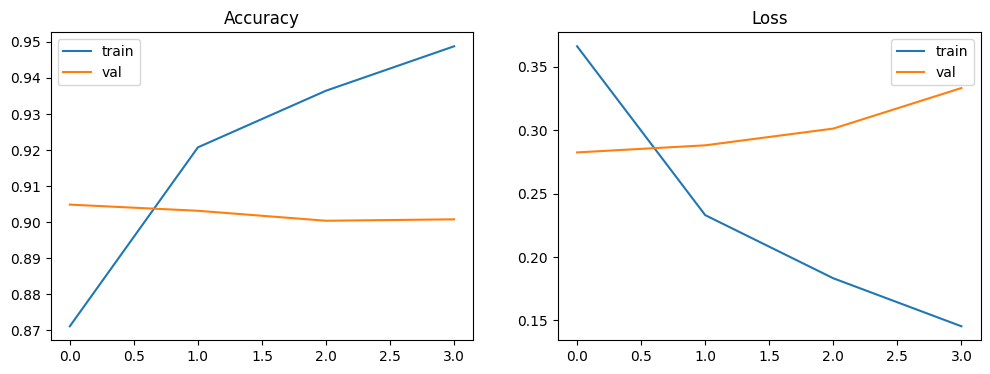

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━

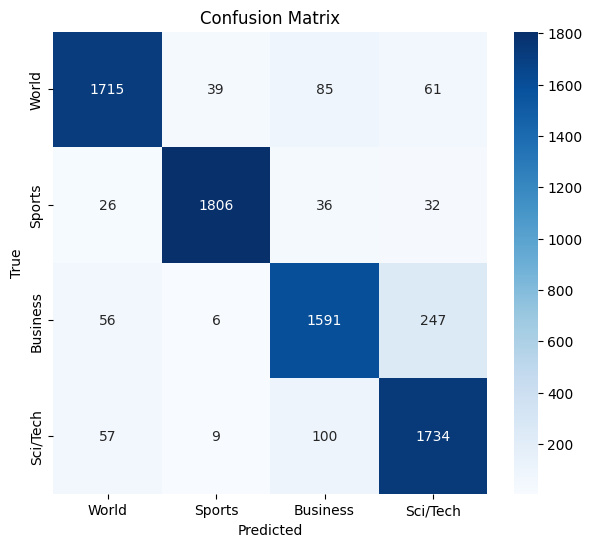

In [19]:
# gather predictions on test set
y_true = []
y_pred = []
for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch)
    preds = np.argmax(probs, axis=1)
    y_pred.extend(preds.tolist())
    y_true.extend(y_batch.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


In [20]:
def predict_text(text):
    seq = text_vectorizer([text])
    probs = model.predict(seq)[0]
    idx = int(np.argmax(probs))
    return CLASS_NAMES[idx], float(probs[idx])

examples = [
    "Apple releases new iPhone with impressive camera upgrades",
    "Scientists discover potential cure for rare disease",
    "Stocks tumble as market reacts to surprise inflation data",
    "How to cook the perfect pasta in 20 minutes"
]

for ex in examples:
    lbl, score = predict_text(ex)
    print(f"Text: {ex}\n -> Predicted: {lbl} (score={score:.3f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Text: Apple releases new iPhone with impressive camera upgrades
 -> Predicted: Sci/Tech (score=0.997)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: Scientists discover potential cure for rare disease
 -> Predicted: World (score=0.551)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Text: Stocks tumble as market reacts to surprise inflation data
 -> Predicted: Business (score=0.887)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Text: How to cook the perfect pasta in 20 minutes
 -> Predicted: Sci/Tech (score=0.520)



In [21]:
model.save("agnews_bilstm_model.h5")
with open("text_vectorizer_vocab.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(text_vectorizer.get_vocabulary()))
print("Saved model and vocabulary.")


Saved model and vocabulary.
